<a href="https://colab.research.google.com/github/Bhuvaneswarij/gitingest/blob/main/Advanced%20time%20series%20method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

In [2]:
warnings.filterwarnings("ignore")


In [3]:
print("\nDownloading dataset...")

In [4]:
start = datetime(1990, 1, 1)
end = datetime.today()


In [5]:
df = pdr.get_data_fred('UNRATE', start, end)
df = df.rename(columns={'UNRATE': 'unemployment'})

In [6]:
print("Dataset downloaded successfully!")
print(df.head())

Dataset downloaded successfully!
            unemployment
DATE                    
1990-01-01           5.4
1990-02-01           5.3
1990-03-01           5.2
1990-04-01           5.4
1990-05-01           5.4


In [7]:
df['rolling_3'] = df['unemployment'].rolling(3).mean()
df['rolling_6'] = df['unemployment'].rolling(6).mean()
df['diff_1'] = df['unemployment'].diff()

In [8]:
df = df.dropna()

In [9]:
values = df[['unemployment']].values

In [10]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

In [11]:
seq_length = 12

In [12]:
X, y = [], []
for i in range(seq_length, len(scaled)):
    X.append(scaled[i-seq_length:i])
    y.append(scaled[i])

In [13]:
X, y = np.array(X), np.array(y)

In [14]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
print("\nData prepared successfully!")


Data prepared successfully!


In [16]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

In [17]:
model.compile(optimizer='adam', loss='mse')
print("\nTraining LSTM model...\n")
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)



Training LSTM model...

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0563
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0152
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4385e-04
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8466e-04
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9108e-04


In [18]:
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_actual = scaler.inverse_transform(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step


In [19]:
print("\nTraining SARIMA model (baseline)...\n")
sarima = SARIMAX(df['unemployment'], order=(2,1,2), seasonal_order=(1,1,1,12))
sarima_fit = sarima.fit(disp=False)



Training SARIMA model (baseline)...



In [20]:

sarima_pred = sarima_fit.predict(start=len(df)-len(y_test), end=len(df)-1)

In [21]:

def metrics(name, true, pred):
    print(f"\n====== {name} ======")
    print("MAE  :", mean_absolute_error(true, pred))
    print("RMSE :", np.sqrt(mean_squared_error(true, pred)))



In [22]:
metrics("LSTM", y_test_actual, y_pred_lstm)
metrics("SARIMA", y_test_actual.flatten(), sarima_pred.values)



====== LSTM ======
MAE  : 0.576483392715454
RMSE : 1.6583726927661988

====== SARIMA ======
MAE  : 0.3515412168236334
RMSE : 1.19300228817408


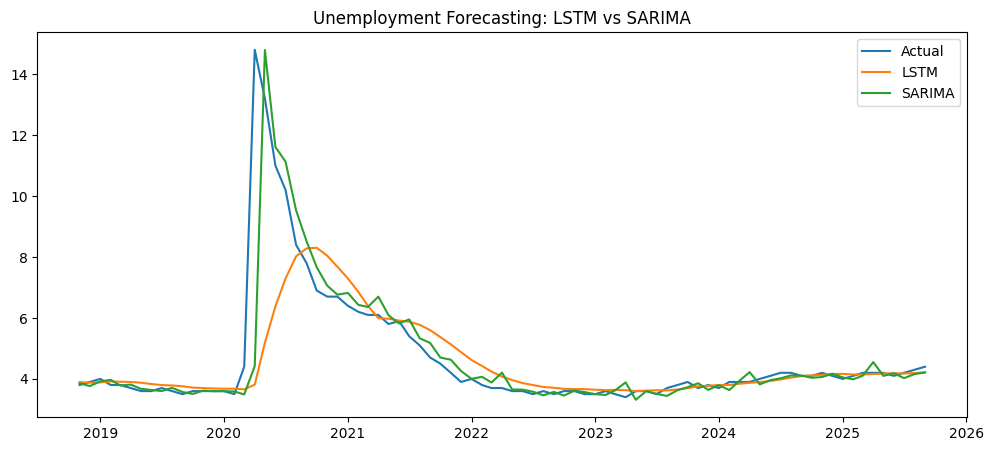

In [23]:
plt.figure(figsize=(12,5))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual')
plt.plot(df.index[-len(y_test):], y_pred_lstm, label='LSTM')
plt.plot(df.index[-len(y_test):], sarima_pred, label='SARIMA')
plt.title("Unemployment Forecasting: LSTM vs SARIMA")
plt.legend()
plt.show()

In [24]:
print("\nProject Completed Successfully!\n")


Project Completed Successfully!

